## Download Tiles

#### Dependencies

In [2]:
import sys
import os

sys.path.append("../src")

from wms.get_wms_crops import get_crop_bboxes

import geopandas as gpd
from shapely.geometry import Point
from owslib.wms import WebMapService
import contextily as ctx
import matplotlib.pyplot as plt

#### Config

In [3]:
output_dir = "D:/cassda-data/street-tiles"
box_source = "../data/geodata/Export_Box_on_Highway.json"
buffer_size = 640  # meter buffer around each point, square bbox

WMS_URL = "https://image.discomap.eea.europa.eu/arcgis/services/GioLand/VHR_2021_LAEA/ImageServer/WMSServer/?request=GetCapabilities&service=WMS"
CRS = "EPSG:3035"  # ETRS89 / ETRS-LAEA
PIXEL_RESOLUTION_M = 2  # 2 meters per pixel

#### Setup

In [4]:
gdf = gpd.read_file(box_source)
gdf.head()

gdf_ch = gpd.read_file(
    r"C:\Users\raffael\FHNW\P-cassda-wildtieruebergaenge_M365 - General\data\exploration\swissBOUNDARIES3D_1_5_LV95_LN02.gpkg",
    layer="TLM_LANDESGEBIET",
)
gdf_ch = gdf_ch.to_crs(CRS)

# remove points outside Switzerland
gdf = gdf[gdf.within(gdf_ch.union_all())]

In [5]:
wms = WebMapService(
    WMS_URL,
    version="1.3.0",
)
layer_name = list(wms.contents)[0]
print(layer_name)

VHR_2021_LAEA


#### Plot Dataset

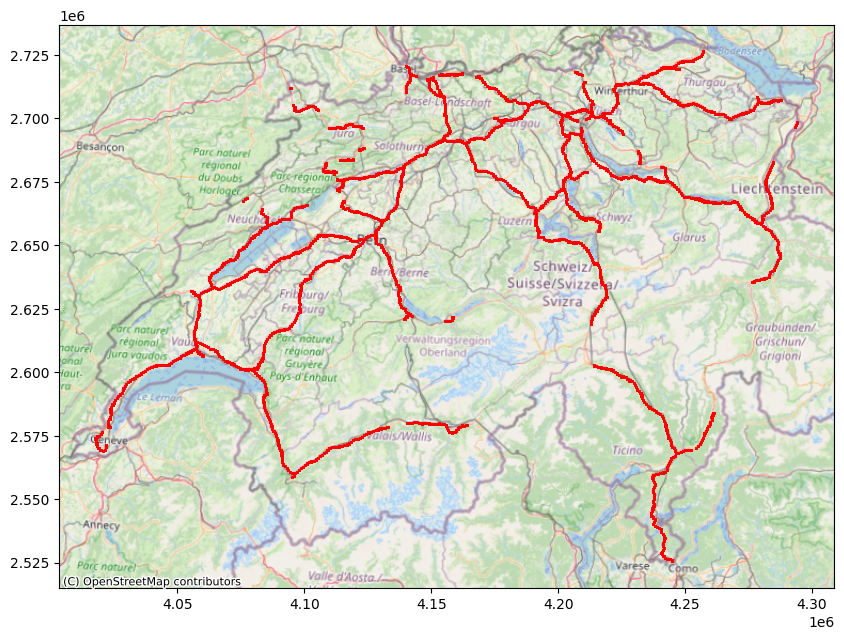

In [6]:
# Plot Dataset on Europe Map
gdf.plot(figsize=(10, 10), color="red", markersize=5)
ctx.add_basemap(
    plt.gca(),
    crs="EPSG:3035",
    source=ctx.providers.OpenStreetMap.Mapnik,
)

Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0
Box Width: 1280.0, Box Height: 1280.0


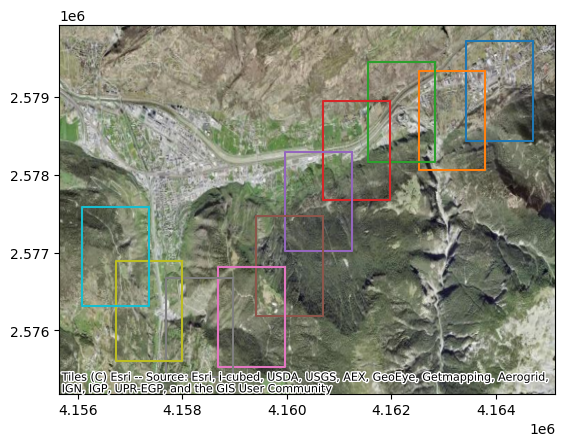

In [7]:
first_10 = gdf.geometry.head(10)
for geom in first_10:
    bbox = geom.bounds  # minx, miny, maxx, maxy
    plt.plot(*geom.exterior.xy)
    print(f"Box Width: {bbox[2] - bbox[0]}, Box Height: {bbox[3] - bbox[1]}")
ctx.add_basemap(
    plt.gca(),
    crs="EPSG:3035",
    source=ctx.providers.Esri.WorldImagery,
)
plt.show()

In [8]:
# for every point create a square around it and request a WMS crop centered on the point
img_format = "image/jpeg"
img_size = (
    int(buffer_size * 2 / PIXEL_RESOLUTION_M),
    int(buffer_size * 2 / PIXEL_RESOLUTION_M),
)  # width, height in pixels

In [9]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
import time

# Thread-safe counter for progress tracking
class ProgressCounter:
    def __init__(self, total):
        self.lock = Lock()
        self.completed = 0
        self.total = total
        self.start_time = time.time()
    
    def increment(self):
        with self.lock:
            self.completed += 1
            elapsed = time.time() - self.start_time
            rate = self.completed / elapsed if elapsed > 0 else 0
            remaining = self.total - self.completed
            eta = remaining / rate if rate > 0 else 0
            print(f"Progress: {self.completed}/{self.total} ({self.completed/self.total*100:.1f}%) - "
                  f"Rate: {rate:.2f} img/s - ETA: {eta:.0f}s")

def download_image_task(args):
    """
    Download a single image (thread-safe wrapper).
    
    Parameters:
    -----------
    args : tuple
        (idx, geom, wms, layer_name, img_size, img_format, image_output_dir, progress)
    
    Returns:
    --------
    tuple : (idx, success, error_msg)
    """
    idx, geom, wms, layer_name, img_size, img_format, image_output_dir, crs, progress = args
    
    try:
        bbox = geom.bounds  # minx, miny, maxx, maxy
        tile_name = f"{int(bbox[0])}_{int(bbox[1])}_{int(bbox[2])}_{int(bbox[3])}"
        img_filename = os.path.join(image_output_dir, f"{tile_name}.jpg")
        
        # Download image
        img = wms.getmap(
            layers=[layer_name],
            srs=crs,
            bbox=bbox,
            size=img_size,
            format=img_format,
        )
        
        # Save to file
        with open(img_filename, "wb") as f:
            f.write(img.read())
        
        # Update progress
        if progress:
            progress.increment()
        
        return (idx, True, None, img_filename)
    
    except Exception as e:
        if progress:
            progress.increment()
        return (idx, False, str(e), None)

def download_images_parallel(gdf, wms, layer_name, img_size, img_format, image_output_dir, 
                             crs=CRS, max_workers=20, limit=None):
    """
    Download images in parallel using multiple threads.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        GeoDataFrame containing geometries
    wms : WebMapService
        WMS service instance
    layer_name : str
        Name of the WMS layer
    img_size : tuple
        (width, height) in pixels
    img_format : str
        Image format (e.g., 'image/jpeg')
    image_output_dir : str
        Directory to save images
    crs : str
        Coordinate reference system
    max_workers : int
        Number of parallel threads (default: 20)
    limit : int
        Maximum number of images to download (None for all)
    
    Returns:
    --------
    dict : Summary with 'success', 'failed', and 'errors' lists
    """
    # Prepare geometries to process
    geometries = gdf.geometry if limit is None else gdf.geometry.head(limit)
    total = len(geometries)
    
    print(f"Starting parallel download of {total} images using {max_workers} threads...")
    
    # Progress counter
    progress = ProgressCounter(total)
    
    # Prepare arguments for each task
    tasks = [
        (idx, geom, wms, layer_name, img_size, img_format, image_output_dir, crs, progress)
        for idx, geom in enumerate(geometries)
    ]
    
    # Execute downloads in parallel
    results = {'success': [], 'failed': [], 'errors': []}
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [executor.submit(download_image_task, task) for task in tasks]
        
        # Collect results as they complete
        for future in as_completed(futures):
            idx, success, error, filename = future.result()
            
            if success:
                results['success'].append((idx, filename))
            else:
                results['failed'].append(idx)
                results['errors'].append((idx, error))
    
    # Print summary
    print(f"\n{'='*60}")
    print(f"Download Complete!")
    print(f"Total: {total} | Success: {len(results['success'])} | Failed: {len(results['failed'])}")
    
    if results['errors']:
        print(f"\nErrors:")
        for idx, error in results['errors'][:10]:  # Show first 10 errors
            print(f"  Image {idx}: {error}")
        if len(results['errors']) > 10:
            print(f"  ... and {len(results['errors']) - 10} more errors")
    
    return results

In [ ]:
# Multi-threaded version (NEW)
image_output_dir = os.path.join(output_dir, "images")
os.makedirs(image_output_dir, exist_ok=True)

# Download with 20 parallel threads
# Set limit=None to download all, or limit=100 to download first 100, etc.
results = download_images_parallel(
    gdf=gdf,
    wms=wms,
    layer_name=layer_name,
    img_size=img_size,
    img_format=img_format,
    image_output_dir=image_output_dir,
    crs=CRS,
    max_workers=20,  # Number of parallel threads
    limit=None       # None = download all, or set a number like 100
)